# N-Body Simulation Report
Dino Bektesevic, 13.02.2018

In [3]:
from os.path import join

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import maxwell, kstest
import scipy as scp

import nbody

%matplotlib inline

## Description of the algorithm and implementation 

The suplied code is mostly inspired by the [Event Driven Simulation](https://algs4.cs.princeton.edu/61event/) chapter from the textbook Algorithms, 4th Edition by Robert Sedgewick and Kevin Wayne with minor adjustments and a wider abstraction. 

The overarching structure that instructs how the simulation is executed is and instance of `TDMSystem`. Through that interface it is possible:
1. to set the number of particles in the simulation,

1. total simulated time,

1. their masses and radii,

1. total time being simulated,

1. initial simulation conditions (particle positions and velocities distributions),

1. set various variables that control the execution (f.e. verbose, optimization factors such as `heapt` etc.),

1. and forward any additional keywords that can instruct additional behaviour of initial sim. conditions if applicable

The code is polymorphic therefore what defines a sensible list of inputs to this class is dependant at least partially on the type of initial conditions that were given to it. Any of the following are valid instantiations of `TDMSystem` class:

In [4]:
s = nbody.TDMSystem(100, 1, verbose=False)
s = nbody.TDMSystem(N_particles=100, t_total=1, p_mass=1, p_r=0.01, p_v=1, p_kin=1, verbose=False)
s = nbody.TDMSystem(100, 1, pos_type="ordered", vel_type="identical", verbose=False)

print("""Init signature:
TDMSystem(N_particles, t_total,                             # Mandatory positional args
          p_mass=1, p_r=0.01, p_v=1.0, p_kin=1.0,           # Particle specifications 
          pos_type='random', pos_func=None,                 # Initial particle positions
          vel_type='random', vel_type=None,                 # Initial particle velocities
          verbose=True, save_t=0.01, heap_t=None,           # Simulation control
          **kwargs)                                         # Additional variables forwarded to init. conditions.
          """)

Init signature:
TDMSystem(N_particles, t_total,                             # Mandatory positional args
          p_mass=1, p_r=0.01, p_v=1.0, p_kin=1.0,           # Particle specifications 
          pos_type='random', pos_func=None,                 # Initial particle positions
          vel_type='random', vel_type=None,                 # Initial particle velocities
          verbose=True, save_t=0.01, heap_t=None,           # Simulation control
          **kwargs)                                         # Additional variables forwarded to init. conditions.
          


There are several different initial conditions implemented and availible as functions. These initial conditions can be selected through the `TDMSystem` class by setting `vel_type` to one of the following identifying strings:
* `identical`, in which case both velocity components per particle are set to `p_v`,
* `ekin_constrained`, in which case the magnitude of velocity components are determined as $0.5\sqrt{2E_{kin}{}/{m}}$,
* `user_defined`, in which case user is expected to suply his own function via `vel_func` keyword and
* `random`, which is the default case when all particles have a uniformly distributed velocities in the range $[-$ `p_v` $, $ `p_v` $>$

or by setting `pos_type` to one of the following strings:
* `ordered`, in which case particles are ordered left to right, bottom to top with specified spacings in between,
* user_defined, in which case user is expected to suply his own function via `pos_func` keyword and
* random, which is the default case when all particles are placed randomly acros the allowed range including spacing from edges.

Prior to placing any particle a check is performed to establish that the total net area of all particles does not exceed the area of the box. This check does not include spacing away from the edges, nor does it include any designated particle spacing. Because the placing occurs iteratively endless loops are still possible if user is not cautious. 

It is required that a user defined function returns two iterables of the same legth that corresponds to the number of particles `N_particles` set in the `TDMSystem`. In addition to keyword arguments `p_r`, `p_v`, `p_mass`, `p_kin` and `verbose` both position and velocity user defined functions will recieve `N_particles` as their first positional argument. Main difference between the two suplied functions is that `pos_func` will recieve the radii as a second positional argument instead of a keyowrd argument. Declaring a user defined function therefore requires `**kwargs` argument. 

Main differences between the functions are shown below. First for positions:

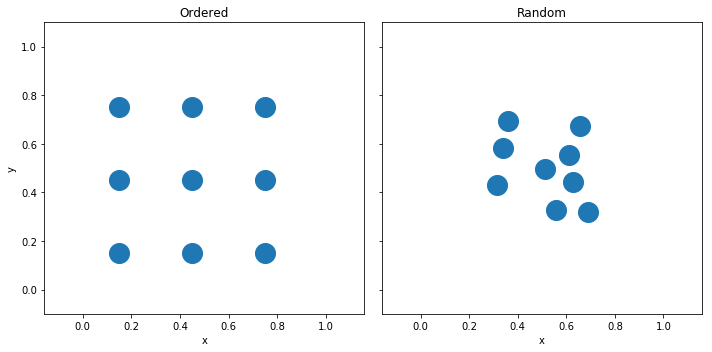

In [5]:
def plot_init_pos(nparticles=9):
    x, y = nbody.ordered_positions(nparticles, 0.05, edgespacing=0.1, pspacing=0.2)
    x1, y1 = nbody.random_positions(nparticles, 0.05, edgespacing=0.3)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    axes[0].scatter(x, y, s=400)
    axes[1].scatter(x1, y1, s=400)
    axes[0].set_title("Ordered")
    axes[1].set_title("Random")

    axes[0].set_ylabel("y")
    for ax in axes:
        ax.set_aspect("equal")
        ax.set_xlabel("x")
        ax.set_xlim([-0.1, 1.1])
        ax.set_ylim([-0.1, 1.1])
        
    plt.tight_layout()

plot_init_pos()

Notice the effects of `edgespacing` and `pspacing` which represent spacing away from the edges and spacing between particles respectively. 

Then for velocities:

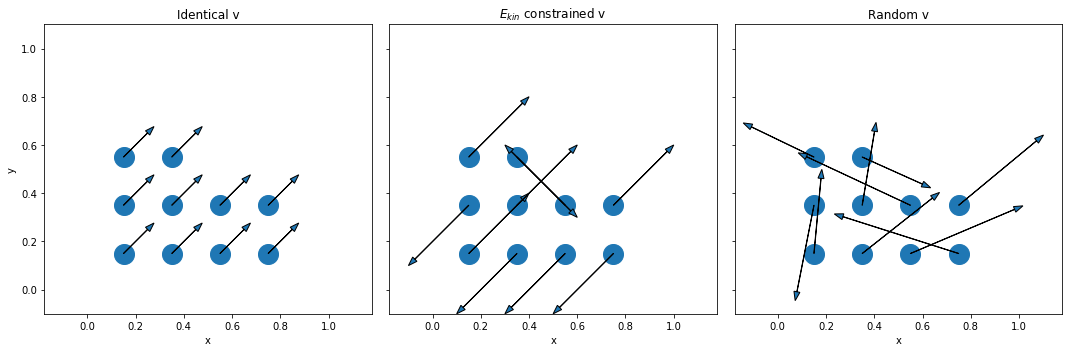

In [6]:
def plot_init_v(nparticles=10):
    x, y = nbody.ordered_positions(nparticles, 0.05)
    v = [
        (*nbody.identical_velocities(nparticles, v=0.1), "Identical v"),
        (*nbody.ekin_constrained_velocities(nparticles, Ekin=0.1), r"$E_{kin}$ constrained v"),
        (*nbody.random_velocities(nparticles, v=0.5), "Random v")        
    ]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    
    i=0
    for vx, vy, title in v:
        for px, py, pvx, pvy in zip(x, y, vx, vy):
            axes[i].arrow(px, py, pvx, pvy, head_width=0.025)
            axes[i].set_title(title)
        i+=1
    
    axes[0].set_ylabel("y")
    for ax in axes:
        ax.scatter(x, y, s=400)
        ax.set_aspect("equal")
        ax.set_xlabel("x")
        ax.set_xlim([-0.1, 1.1])
        ax.set_ylim([-0.1, 1.1])
        
    plt.tight_layout()

plot_init_v()

As you can see all velocity generating functions take the number of particles as the first and only mandatory positional argument and can get some kind of scaling keyword value `v` (or `Ekin` for the obvious case of velocities constrained by kinetic energy per particle). Additional keyword that can be sent to `random_velocities` is `scaling`. `scaling` controls the number of digits of randomly generated `float` numbers, by default it is set to `10000`. 

### Event driven loop

The TDM system is described by the positions and velocities of particles which can be initiated in any of the above described manners. In addition to that a series of `Event`'s is initialized which represent future particle-particle and particle-box collisions, provided the microstate of the system remains unchanged.

Events are stored in a priority queue. A priority queue is a heap in which elements have priority associated with them. A priority queue is, basically, an array with an invariant
        $$\mathrm{heap}[k] <= \mathrm{heap}[2k+1]$$
        $$\mathrm{heap}[k] <= \mathrm{heap}[2k+2]$$  
Sorting a heap preserves this invariant. This means that the zeroth element of a heap is always the smallest element of the heap, priority-vise. Because two `Events` are compared on the basis of the time at which they occur the zeroth element of the heap will always be the earliest `Event` that will occur.      
System's microstate is then evolved to the time of the first `Event`, displacing all particles by their respective current velocities multiplied by the time `dt` leading up to the event. `Event`, i.e. collision, is executed and involved particle states are changed.        
New `Events` are generated for involved `Event` objects, when applicable, and inserted into the heap. `Events` involving the two objects participating in the executed `Event` created prior to executing the current `Event` but scheduled at a later time, are now invalidated.      
Becase the newly generated `Events` are kept in a priority queue we are again guaranteed that the first heap event will be the one that occurs closes to current simulation time. We can propapage the current state up to the time of the next `Event`, execute it, generate new `Events` for involved objects, invalidate old `Events` pertaining to involved objects and repeat the procedure untill the we exhaust the heap - because, remember, we are not inserting `Events` that happen after the total simulated time, `totalt`.

In my adaptation of the algoithm `heap_t` argument can be sent to `TDMSystem` as a means of optimizing the memory imprint of the simulation for longer total simulated times `totalt`. `Event` will inserted into the event queue if the time at which the `Event` would occur is lower than the total simulated time, `totalt`, and if the difference, `dt`, between the time the `Event` is scheduled to happen and current smulation time, `t`, is not larger than `heapt` attribute. `Event` for which it is safe to assume will be invalidated by intermediate collisions will never be generated and pushed into the event queue thus reducing the memory demands of the simulation.


### Event handling

Most of the mathematical manipulations were taken from [Algorithms, 4th ed.](https://algs4.cs.princeton.edu/61event/) but there exist other, more explicit, sources such as [William Carver's sollution](http://williamecraver.wixsite.com/elastic-equations). There are essentially 2 types of events that are recognized:
* `Particle`-`Particle` collisions
* `Particle`-`Wall` collisions

`Particle`-`Wall` collisions are trivially resolved by using reflecting boundary conditions. Depending on the `Wall.orientation` corresponding velocity component will change sign. The interesting part of `Particle`-`Wall` collisions is the collision prediction. There are 3 cases that need to be taken into account:
* particle's velocity component magnitude is zero, in which case a collision will never occur,
* particle's velocity component is positive, in which case collision with the upper limit will occur in $$\Delta t = (L-r-q_i)/v_i$$ where $r$ is the radius of the particle, $L$ is the lenght of the box (taken to be 1 for simplicity), $q_i$ observed coordinate ($x$ or $y$ for a 2D case) and $v_i$ the velocity component in the same direction as the observed coordinate ($x$ or $y$ for a 2D case),
* or particle's velocity component is negative, in which case collision with a lower limit will occur in $$\Delta t = (r-q_i)/v_i$$ where it is assumed that the corner of the box originates in $(0,0)$

`Particle`-`Particle` collision prediction and resolution is a bit more complicated than the simple reflecting boundary condition. A collision between two particles $i$ and $j$ will occur when the distance between their center coordinates is equal to the sum of their radii $(r_i+r_j)=\sigma=|\vec{r_i} - \vec{r_j}|$. We are interested in obtaining if and when the two particles will collide so we rewrite the equation of motions for both particles as:
$$ \vec{r_i} = \vec{r_i} + \Delta t \vec{v_i}$$
$$ \vec{r_j} = \vec{r_j} + \Delta t \vec{v_j}$$
incorporating the equations into the collision conditions and solving for $\Delta t$ we get the following cases:
* $\Delta t=\infty$ for $\Delta\vec{v}\cdot\Delta\vec{r} >= 0$ or $d<0$ 
* otherwise $$\Delta t=  -\frac{\Delta \vec{v}\cdot \Delta \vec{r} + \sqrt{d}}{\Delta v^2}$$

where $d=\Delta\vec{v}\cdot\Delta\vec{r} - \Delta v^2(\Delta r^2-\sigma^2)$. To be completely explicit: $\Delta\vec{v}\cdot\Delta\vec{r}=(x_i-x_j)({v_x}_i - {v_x}_j)+(y_i-y_j)({v_y}_i - {v_y}_j)$ where at the time of collision particle $i$ has the coordinates $(x_i, y_i)$ and velocity vector $(v_{xi}, v_{yi})$ and analogous applies for particle $j$.     
Once the particle states are propagated to the time of the collision $t+\Delta t$ the resolution of `Particle`-`Particle` collision is handled by conserving momentum and impulse:
$$||J|| = \frac{2m_im_j\Delta\vec{v}\cdot\Delta\vec{r}}{\sigma(m_i+m_j)}$$
or per component ($x$ or $y$):
$${J_q} = \frac{J\Delta {r_q}}{\sigma}$$
it follows that new velocities for particles $i$ and $j$ are:
$$\begin{align*} 
\vec{v_i} &= \vec{v'_i} + \vec{J}/m_i \\
\vec{v_j} &= \vec{v'_j} - \vec{J}/m_j \\
\end{align*}$$
Where $\vec{v'}$ is the old velocity of particle $i$ or $j$.

A test of correctnes of implementation of collisional physics can be performed by manually colliding particles in a couple of standard cases of elastic head-on collisions. Following cases are examined:

1) Same mass, projectile is moving with velocity $v_1$, target at rest. Expected outcome is a stationary projectile and a target moving with $v_1$

In [7]:
p = nbody.Particle(pos=(0, 0), vel=(1, 0), mass=1, r=1)
t = nbody.Particle(pos=(3, 0), vel=(0, 0), mass=1, r=1)

dt = p.dt2Hit(t)
p.move(dt)
p.collide2particle(t)

print("Projectile post collision: {0}".format(p))
print("Target post collision:     {0}".format(t))

Projectile post collision: <nbody.particle.Particle(pos=(1.00, 0.00), vel=(0.00, 0.00))>
Target post collision:     <nbody.particle.Particle(pos=(3.00, 0.00), vel=(1.00, 0.00))>


2) Same mass, both projectiles are moving with velocity $v$ towards each other. Expected outcome is reflection.

In [8]:
p = nbody.Particle(pos=(0, 0), vel=(1, 0),  mass=1, r=1)
t = nbody.Particle(pos=(3, 0), vel=(-1, 0), mass=1, r=1)

dt = p.dt2Hit(t)
p.move(dt)
p.collide2particle(t)

print("Projectile post collision: {0}".format(p))
print("Target post collision:     {0}".format(t))

Projectile post collision: <nbody.particle.Particle(pos=(0.50, 0.00), vel=(-2.12, 0.00))>
Target post collision:     <nbody.particle.Particle(pos=(3.00, 0.00), vel=(2.12, 0.00))>


3) Target mass is much greater than projectile mass, projectile is moving with the velocity $v$. Expected outcome is stationary target and a reflected projectile.

In [9]:
p = nbody.Particle(pos=(0, 0), vel=(1, 0), mass=1,       r=1)
t = nbody.Particle(pos=(3, 0), vel=(0, 0), mass=1000000, r=1)

dt = p.dt2Hit(t)
p.move(dt)
p.collide2particle(t)

print("Projectile post collision: {0}".format(p))
print("Target post collision:     {0}".format(t))

Projectile post collision: <nbody.particle.Particle(pos=(1.00, 0.00), vel=(-1.00, 0.00))>
Target post collision:     <nbody.particle.Particle(pos=(3.00, 0.00), vel=(0.00, 0.00))>


### Units

System is scaled by $10^{-8}$ meters such that particle radius of 0.01 represents 1Å or $10^{-10}$ meters. This makes a unit box 100x100Å big.    
As per the equipartition theorem, the average energy of each particle of an ideal gas scaled by $kT/2$ per degree of freedom. This makes $kT$ the characteristic energy for a particle in a simulation with 2 degrees of freedom. We must not forget to scale Joules to account for the scaled meters. This provides us with an opportunity to scale the energy to a more reasonable unit as well:
$$J=\frac{\mathrm{kg}\mathrm{m}^2}{\mathrm{s}^2} \rightarrow 10^{-16}J \rightarrow 6.24218\cdot10^{18}\cdot10^{-16}\mathrm{eV} = 624.2\mathrm{eV}$$
We must make sure Boltzman factor units correspond to the rest of the code as well $$k_B = 8.617\cdot10^{−5}\frac{\mathrm{eV}}{K}$$ Picking a room temperature of $300K$ we see that the characteristic particle energy corresponds to $0.02585\mathrm{eV}$. Reasonable values for `v` would then be $\approx 0.24$.

## Verification

![image](out_pos1_scaled.gif)

To verify our results we must derive the Maxwell-Boltzman distribution $dN_i/dv$ in 2D. Starting from $f(q, p)\propto \exp(-E/k_BT)$, we state that a probability that a particle has energy E in the range $E$ to $E+dE$ is
$$f(q,p)dE = Ae^\frac{-E}{k_BT}dE$$
noting that the average number of particles, $N_i/N$, with an energy in the range $E$ to $E+dE$ is proportional to this quantity, that for an ideal gas $E=mv^2/2$ and that $dE=mvdv$ we can rewrite the expression as
$$n(E)dE = NAe^\frac{-E}{k_BT}dE = NAve^\frac{-mv^2}{2k_BT}dv$$
for a 1D case we could normalize the expression and retrieve the normalization constant but because $\vec{v} = v_x\hat i + v_y\hat j$ and $v^2 = v_x^2+v_y^2$ we need to average over all possible directions of velocity by integrating from $0$ to $2\pi$
$$n(v)dv = 2\pi NA^2v\exp\left(\frac{-m(v_x^2+v_y^2)}{2k_BT}\right)dv$$
Recognizing that normalizing that expression $f(q, p)\propto A^2v\exp\left(\frac{-mv_x^2}{2k_BT}\right)\exp\left(\frac{-mv_y^2}{2k_BT}\right)$ is, esentially, repeating the same procedure for normalization in the 1D case we can skip actually doing the substitution and solving the integral and use the final result $A=\sqrt{m/2\pi kT}$ to conclude that the number of particles with velocity in an interval $dv$ around $v$ is
$$n(v)dv = N\frac{m}{k_BT}v\exp\left(-\frac{mv^2}{2k_BT}\right)dv$$
analogous to this lies the distribution of number of particles with energies in an interval $dE$ around $E$
$$n(E)dE = N\frac{m}{k_BT}\sqrt{E}\exp\left(-\frac{E}{k_BT}\right)dE$$

We define the 2D Maxwell distribution analytically here so we can use it later on for comparisons with histograms.

In [10]:
def maxwell2D(x, scale):
    return 2.0*scale**2*x*np.exp(-x**2/scale)

We also define the CDF for a 2D Maxwell distribution for later use. By definition a CDF is a integral of PDF from negative infinity to the point of interest, is non-negative and approaches 1 in the limit where the point we're looking the CDF for goes into infinity. We simplify the lower limit of out integral from negative infinity to a 0 because we are confident that that is the lower limit of Maxwellian distributions. We also know that the scaling factor $k_BT$ will never be negative. Therefore:

$$CDF=\int_{-\infty}^{x_0}f(v)dv=\int_{0}^{x_0}e^{-\frac{mv^2}{k_BT}}dv=\frac{k_BT}{2}\left(1-e^{-\frac{mv_0^2}{k_BT}}\right)$$

In [11]:
def maxwell2Dcdf(x, scale):
    return (1-np.exp(-x**2/scale))

We can verify this by evaluating our `maxwell2D` on a uniformly sampled velocity grid by finding the indice where the sum of the sample up to the indice is approximately half of the total the total sum of that sample and then by finding approximately the indice where our CDF is 0.5. These two indices should roughly match up.

Half of sample total sum 245398377.85213938.
Guessed index is 4110 and the value of sum at that location is 245563854.32329425
The value when our CDF is closest to 0.5: 0.5001071109213671
The CDF index at 0.5 is 4110


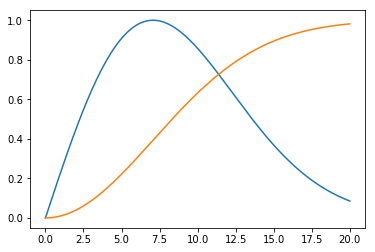

In [12]:
x = np.linspace(0, 20, 10000)
maxw = maxwell2D(x, scale=100)
maxcdf = maxwell2Dcdf(x, scale=100)
plt.plot(x, maxw/maxw.max())
plt.plot(x, maxcdf)

print("Half of sample total sum {}.".format(sum(maxw)/2))
i = 4110
print("Guessed index is {} and the value of sum at that location is {}".format(i, sum(maxw[:i])))
ival = maxcdf[(maxcdf>0.4999999)][0]
print("The value when our CDF is closest to 0.5: {}".format(ival))
print("The CDF index at 0.5 is {}".format(i, np.where(maxcdf>ival)[0][0]))

We can inspect a simulation with 100 particles, with radius $0.02L_{box}$ and $E_{kin}=0.02582eV$, placed in a box in an ordered fashion by plotting simulation states at the start and the end of the simulation. 

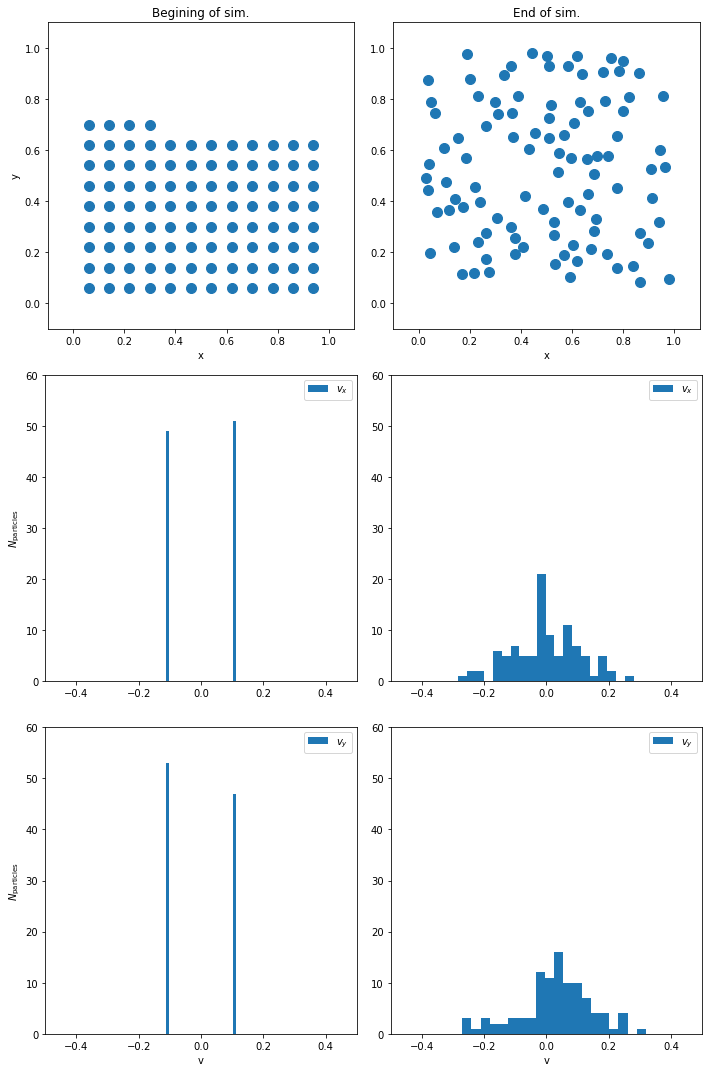

In [13]:
def plot_sim_states(start, end, **kwargs): 
    fig, axes = plt.subplots(3, 2, figsize=(10,15))
    nbody.plot_positions(axes[0,0], start["x"], start["y"], **kwargs)
    nbody.plot_positions(axes[0,1], end["x"], end["y"], **kwargs)
    
    nbody.hist_velocities(axes[1,0], start["vx"], label=r"$v_x$", **kwargs)
    nbody.hist_velocities(axes[1,1], end["vx"],   label=r"$v_x$", **kwargs)
    nbody.hist_velocities(axes[2,0], start["vy"], label=r"$v_y$", **kwargs)
    nbody.hist_velocities(axes[2,1], end["vy"],   label=r"$v_y$", **kwargs)

    #pos plots
    axes[0,0].set_xlabel("x")
    axes[0,0].set_ylabel("y")
    axes[0,1].set_xlabel("x")
    
    #vel plots
    axes[1,0].set_ylabel(r"$N_{\mathrm{particles}}$")
    axes[2,0].set_ylabel(r"$N_{\mathrm{particles}}$")
    axes[2,0].set_xlabel(r"v")
    axes[2,1].set_xlabel(r"v")
    #axes[0,1].set_title("End of sim.")
    
    axes[0,0].set_title("Begining of sim.")
    axes[0,1].set_title("End of sim.")

folderpath = "100p_5s_ordered_ekinconstr_normal"
start = nbody.snapshot_data(join(folderpath, "snapshot_0.0"))
end   = nbody.snapshot_data(join(folderpath, "snapshot_4.991885228"))

plot_sim_states(start, end, bins=20, ylim=(0, 60), xlim=(-0.5, 0.5))
plt.tight_layout()

On first glance the simulation seems to be producing the desired effect - collisions have converted a binomial distribution of speeds into a Maxwell-Boltzman-like distribution. However, the statistic is small with the majority of bins being occupied by less than 10 particles. To get a better by-eye estimate of how close this distribution is to a Maxwell-Bolzmann distribution it's better to plot the $|v|$ distribution and compare it to the MB distribution derived above. Also plotted is the change in total kinetic energy in the simulation as a function of time, from which we can see that there is almost no change in the total energy from which we start the simulation.

As noted above the used $E_{kin}=0.02582eV=mv^2/2$ which indicates that the expected seen $v=0.22$. This seems to be in agreement with the produced histogram, below, where we retrieved a slightly higher value of 0.3. Resolving the units for the most occupied peak in that histogram and calculating the velocity gives us $v=1607.8m/s$. Determining the ideal gas' most probable velocity:
$$E_\mathrm{kin} = \frac{mv^2}{2} = \frac{2}{2}RT \rightarrow v = \sqrt{\frac{2RT}{M_{H_2}}} = \sqrt{\frac{2\cdot8.3145\cdot300}{0.002}} = 1579.35\frac{m}{s}$$

We can extract the pressure of the system from the total energy of the gas by observing the average force imparted by a particle impact with a wall. The force due to one particle is:
$$F = \frac{\Delta p}{\Delta t} = \frac{mv_i^2}{L}$$
because a single particle imparts $\Delta p = p_i - p_f = p_i - (-p_i) = 2p_i$ momenta during a wall collision (due to reflective boundary conditions) and the average time between two collisions is the time it takes that particle to traverse the length of the box $L$ with an average speed $\bar v_i$ ($i$ indicating direction of movement, either $x$ or $y$) is $\Delta t = 2L/v_i$. The total force of all particles on that wall is a linear combination of indivitual collisions: 
$$ F = \frac{Nm\bar v^2_i}{L}$$
In two dimensions the total squared speed $v$ is given by $\bar v^2 = \bar v_x^2 + \bar v_y^2$ and recognizing that there are no prefered directions, thus setting $\bar v_x^2 = \bar v_y^2$, we see that $\bar v_i = \bar v^2 /2$. The total force can then be written as:
$$F = \frac{Nm\bar v^2}{2L}$$
Pressure can then be defined for a 2D case as this force exherted over the wall length $L$: 
$$P = \frac{F}{L} = \frac{Nm\bar v^2}{2L^2}$$
I find this to be a particularily weird statement because pressure goes as the area of the box - not the length of the side. One $L$ stays around from the $\Delta t$ and the other $L$ enters the equation through our definition of $P=F/L$. This can be rewritten in terms of kinetic energy $mv^2/2$ as:
$$P = \frac{NE_{kin}}{L^2} \rightarrow PA = NE_{kin} = E_{tot} $$
Given that we set our box side lengths to 1 there is an equality between the pressure of the system and its total kinetic energy. As you'll see in examples below simulated systems are all very non-dense and have very low pressures on the order of 0.01 to 1 Pascals or 0.01 to 1 microns of Hg.

Average total energy of the system is 12.925000000000141eV.
Maximal total energy of the system is 12.925000000000338eV.
Minimal total energy of the system is 12.92499999999997eV.


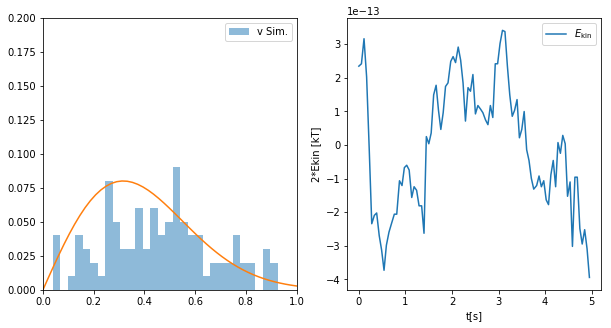

In [32]:
def plot_v_totekin(data, which=-1, scale=0.2, loc=0, figsize=(10, 5), **kwargs):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    vx, vy = data["vx"][which], data["vy"][which]
    v = np.sqrt(vx**2 + vy**2)
    weights = np.ones_like(v)/len(v)
    nbody.hist_velocities(axes[0], v, weights=weights, label="v Sim.", **kwargs)
    
    maxv = v.max()+v.max()/10.
    x = np.linspace(0, maxv)
    y = maxwell2D(x, scale=scale)
    axes[0].plot(x, 2*y/y.sum(), label="MB theoretical")
        
    nbody.plot_Etot(axes[1], data)

folderpath = "100p_5s_ordered_ekinconstr_normal2"
simdat = nbody.sim_data(folderpath)
plot_v_totekin(simdat, scale=0.2, bins=30, alpha=0.5, ylim=(0, 0.2), xlim=(0, 1))

This poor result is expected. Our system contains only 100 particles and we are only plotting the last snapshot in the simulation. This means that our end result will be heavily undersampled. In fact I'd expect it to be nearly randomly distributed.

Ideally we would like to see if there exists a stronger convergence to Max.-Boltz. distribution when averaging over more time-steps. Unfortunatelly, there exists a problem when doing this in an event-driven simulation because the time steps are not uniformly sampled. There exists a selection bias towards those microstates when there exists a higher number of particles with large velocities that are more probale of to collide. Therefore the sampling around such events will be denser than the sampling around events when there are no collisions.     

The end result of that effect is that the snapshots are not necessarily two completely independent events where all positions and velocities are totally random result of hundreds of collisions occuring in between the snapshots, but that they are instead correlated. It is users responsibility to ensure these conditions are met by making sure that the number of collisions per particle between two snapshots is at least approximately 1.

We can still show a stronger convergence towards the Max-Boltz. distribution by making sure we sample the state more densely. This can be done by increasing the number of particles in the simulation. We repeat the procedure for a 1000 particles 5 seconds simulation. The radii have been reduced to $0.01L_\mathrm{box}$ to fit them all in and `p_kin` was set to 0.04. We see that this corresponds to a Maxwell-Boltzmann distribution to a much higher degree.

Average total energy of the system is 20.700000000002657eV.
Maximal total energy of the system is 20.70000000000376eV.
Minimal total energy of the system is 20.70000000000019eV.


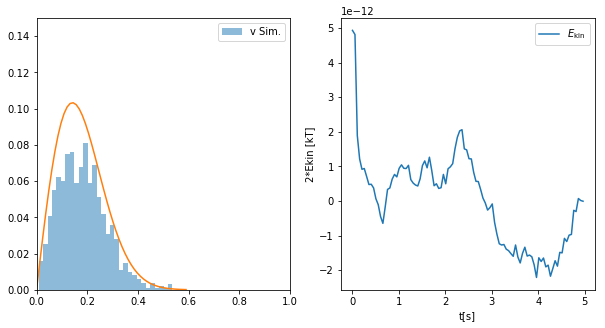

In [33]:
folderpath = "1000p_5s_ordered_ekinconstr_normal"
simdat = nbody.sim_data(folderpath)

plot_v_totekin(simdat, scale=0.04, bins=30, alpha=0.5, ylim=(0, 0.15), xlim=(0, 1))

It is posible to go a step further and exchange the microcanonical ensamble by a canonical one. This can be done by averaging the distributions of velocities of a series of identical simulations as shown bellow. Particles were started in an `ordered` initial state with a `ekin_constrained` velocity distribution (`p_kin` was set to 1) and 20 such simulations were averaged over to produce the following plot.

(0, 3)

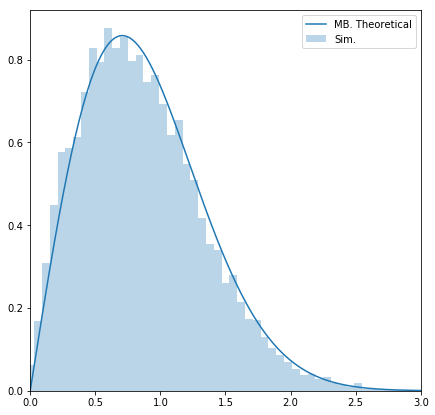

In [29]:
import nbody
import matplotlib.pyplot as plt
import scipy as scp

res = []
for i in range(20):
    res.append(nbody.sim_data("test/"+str(i)))

fig, ax = plt.subplots(figsize=(7, 7))

x = np.linspace(0, 5, 5000)
y = maxwell2D(x, scale=1)
ax.plot(x, y, label="MB. Theoretical")

nbody.plot_avg_v(ax, res, bins=50, extent=(-3, 3))

ax.set_xlim((0, 3))

## Quantifying the relaxation period and similarity to Maxwell-Boltzmann distribution

In priciple because this is an Event driven simulation relaxation period occurs during a very small number of snapshots that occur at the start of the simulation but what we're interested in is quantifying the relaxation period in terms of simulation time.           
Whether or not the relexation period has been reached is easily determined by observing the distributions of either velocity component. Examples of this for a 100 particle and a 1000 particle simulation are shown bellow. 

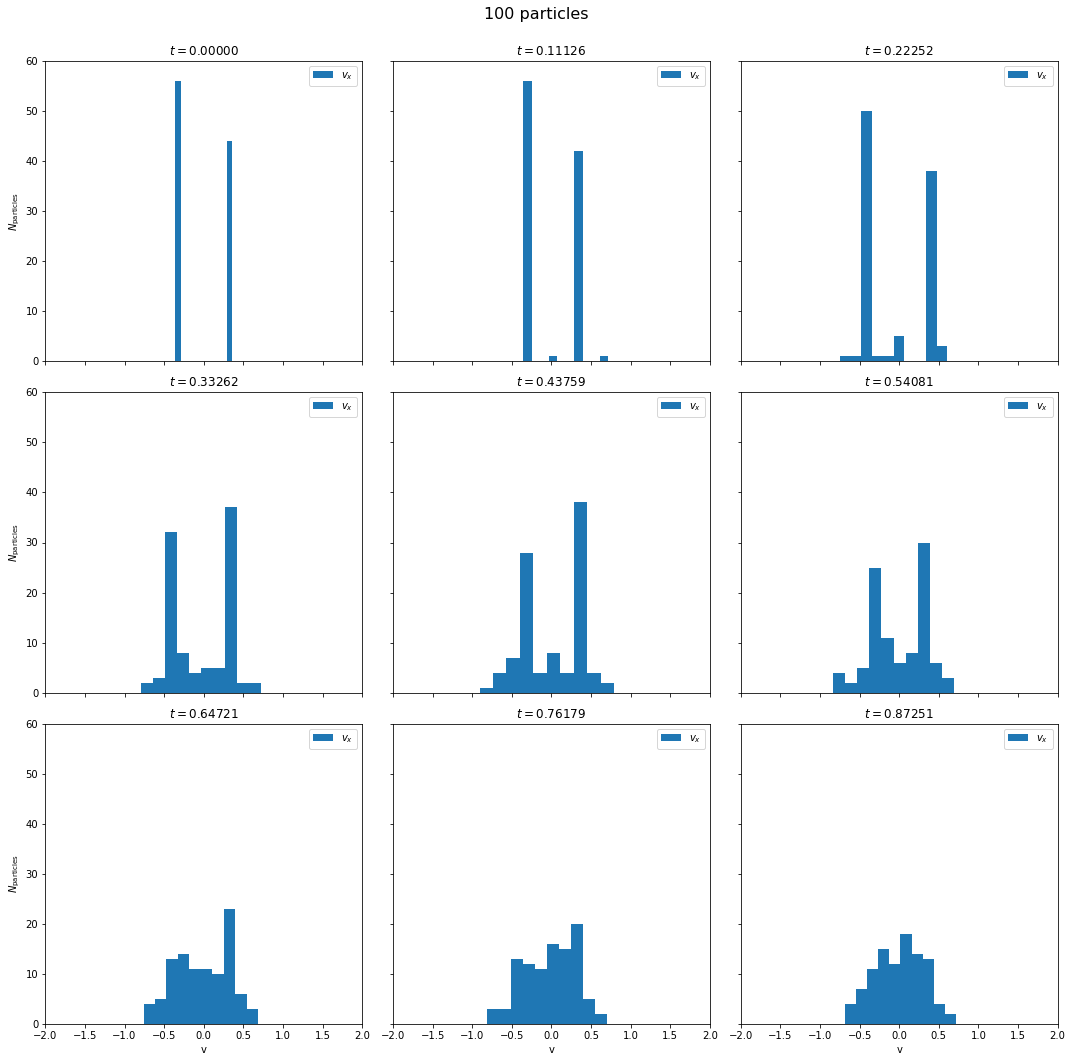

In [17]:
folderpath = "100p_5s_ordered_ekinconstr_normal2"
simdat = nbody.sim_data(folderpath)

fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
plt.suptitle('100 particles', fontsize=16)

ax = np.ravel(axes)
for i in range(9):
    vx, t = simdat[2*i]["vx"], simdat[2*i]["t"][0]
    nbody.hist_velocities(ax[i], vx, bins=10, label=r"$v_x$", title=r"$t=%.5f$"%t, ylim=(0, 60))
    
axes[2,0].set_xlabel(r"v")
axes[2,1].set_xlabel(r"v")
axes[2,2].set_xlabel(r"v")

axes[0,0].set_ylabel(r"$N_{\mathrm{particles}}$")
axes[1,0].set_ylabel(r"$N_{\mathrm{particles}}$")
axes[2,0].set_ylabel(r"$N_{\mathrm{particles}}$")

plt.tight_layout()
plt.subplots_adjust(top=0.93)

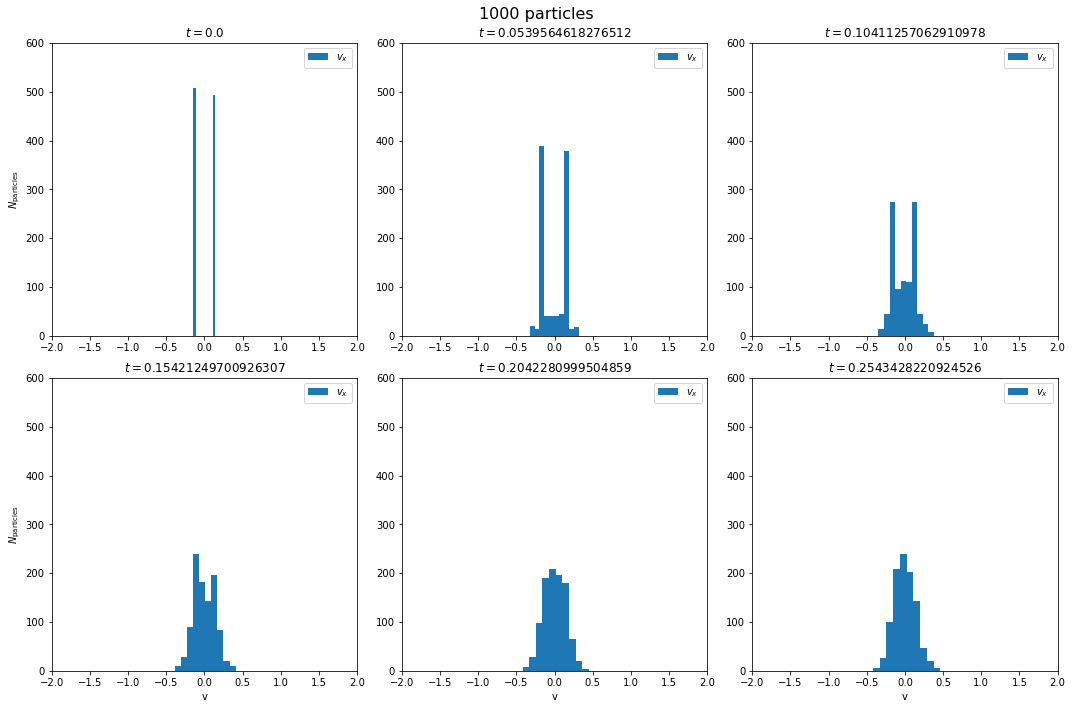

In [18]:
folderpath = "1000p_5s_ordered_ekinconstr_normal"
simdat = nbody.sim_data(folderpath)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plt.suptitle('1000 particles', fontsize=16)

ax = np.ravel(axes)
for i in range(6):
    vx, t = simdat[i]["vx"], simdat[i]["t"][0]
    nbody.hist_velocities(ax[i], vx, bins=10, label=r"$v_x$", title=r"$t={0}$".format(t))

axes[1,0].set_xlabel(r"v")
axes[1,1].set_xlabel(r"v")
axes[1,2].set_xlabel(r"v")

axes[0,0].set_ylabel(r"$N_{\mathrm{particles}}$")
axes[1,0].set_ylabel(r"$N_{\mathrm{particles}}$")

plt.tight_layout()
plt.subplots_adjust(top=0.93)

Relaxation period is highly dependant on the initial system setup. Relaxation period for a randomly positioned particles with random velocities is much shorter than for an system where particles are ordered and with identical velocities.

Relaxation period also depends on the number of particles used in the simulation. Simulations with more particles will have shorter relaxation time than those that have smaller number of particles.

The main connection between these variables is the number of collisions that occur on average per particle. Bellow are plots of the number of collisions against simulation time for each particle for both simulations(100 and 1000 particles).      
Plotted are also average numbers of collisions per time step across all particles. Error bars represent the standard deviation of the average number of collisions per particle for that time step. Vertical lines represent the times of 0.875 seconds and 0.2 seconds at which each of the 100 and 1000 particle simulations seemingly passed relaxation period as evident by the graphs above.

It is evident that both simulations equilibrate after approximately the same number of average collisions per particle (10 to 15 collision) despite the fact that there's a factor of 10 difference in the number of particles for the same initial conditions. This leads me to conclude that average number of collisions per particle is a good by-eye estimate of relaxation period. 

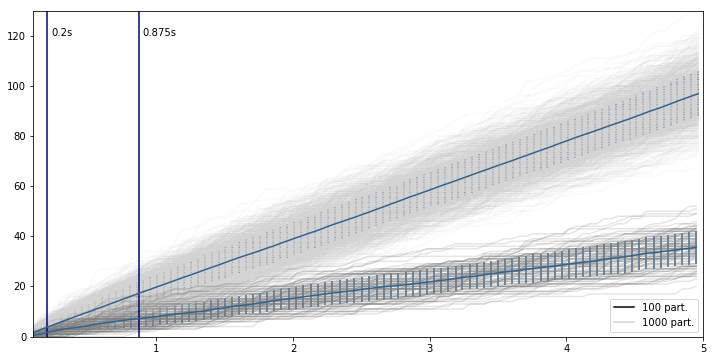

In [19]:
def getavgstd(data):
    avgs = map(sum, data["ncollisions"])
    div = lambda x: np.divide(x, len(data[0]))
    avg = map(div, avgs)
    std = map(np.std, data["ncollisions"])
    return list(avg), list(std)

s1 = nbody.sim_data("100p_5s_ordered_ekinconstr_normal2")
s2 = nbody.sim_data("1000p_5s_ordered_ekinconstr_normal")

s1avg, s1std = getavgstd(s1)
s2avg, s2std = getavgstd(s2)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(s2["t"], s2["ncollisions"], color="lightgray", alpha=0.1)
ax.plot(s1["t"], s1["ncollisions"], color="gray",      alpha=0.2)

ax.errorbar(s1["t"][:,0], s1avg, yerr=s1std, color="#33638DFF")
ax.errorbar(s2["t"][:,0], s2avg, yerr=s2std, color="#33638DFF")

ax.axvline(0.2, color="navy")
plt.text(0.23, 120, "0.2s")

ax.axvline(0.875, color="navy")
plt.text(0.9, 120, "0.875s")

ax.set_xlim([0.1, 5])
ax.set_ylim([-0.1, 130])

# for purposes of legend legibility
ax.plot([-10,-10], color="black", label="100 part.")
ax.plot([-10,-10], color="lightgray", label="1000 part.")

plt.legend()

A more statistically significant estimate of relaxation period can also be given by a Kolmogorov-Smirnov goodness-of-fit test. A KS test uses the maximal difference between the cumulative distribution function of the underlying distribution (Max.-Boltz.) and the velocity distribution of the simulated sample.       
Dependent on the sample size and distribution the KS test will inform us if it is probable that the measured set originated from the provided CDF or not. For larger datasets ($N>50$), this is a robust test usefull when testing if the data belongs to a given distribution. 

KS test gives us a quantifiable way to state when our system has equilibrated without the need for guessing as was done above. An example for 100 particles is provied below.

Looking back up at the distribution of velocities for a 100 particles case it is not obvious that the distribution could be attributed to a Maxwell-Boltzman distribution at all. If anything it looks more like a random sample of velocities (of course this is not completely true, reducing the number of bins reproduces something alike a Maxwellian). I find it very interesting that even for a per-snapshot CDF for a 100 particles we can not outright reject that velocities did not come from a Maxwell-Boltzmann distribution as we can see by looking at the KS test and the CDFs. The overall behaviour is convergent to an MB distribution with `p` values spiking to 0.4 after a second of simulation. 

Meanwhile a per-snapshot KS test for 1000 partices shows a much faster convergence towards the MB CDF but the p-values remain relatively low (`p`$\approx$0.4). Because there is a larger number of particles in the simulation KS test will not allow larger deviations from MB distribution. Naturally, there is still a lot of variance snapshot from snapshot because of the nature of the simulation but if velocities were averaged over several time steps, or even better several simulations, a strong correspondence evident in large `p` values would become obvious.

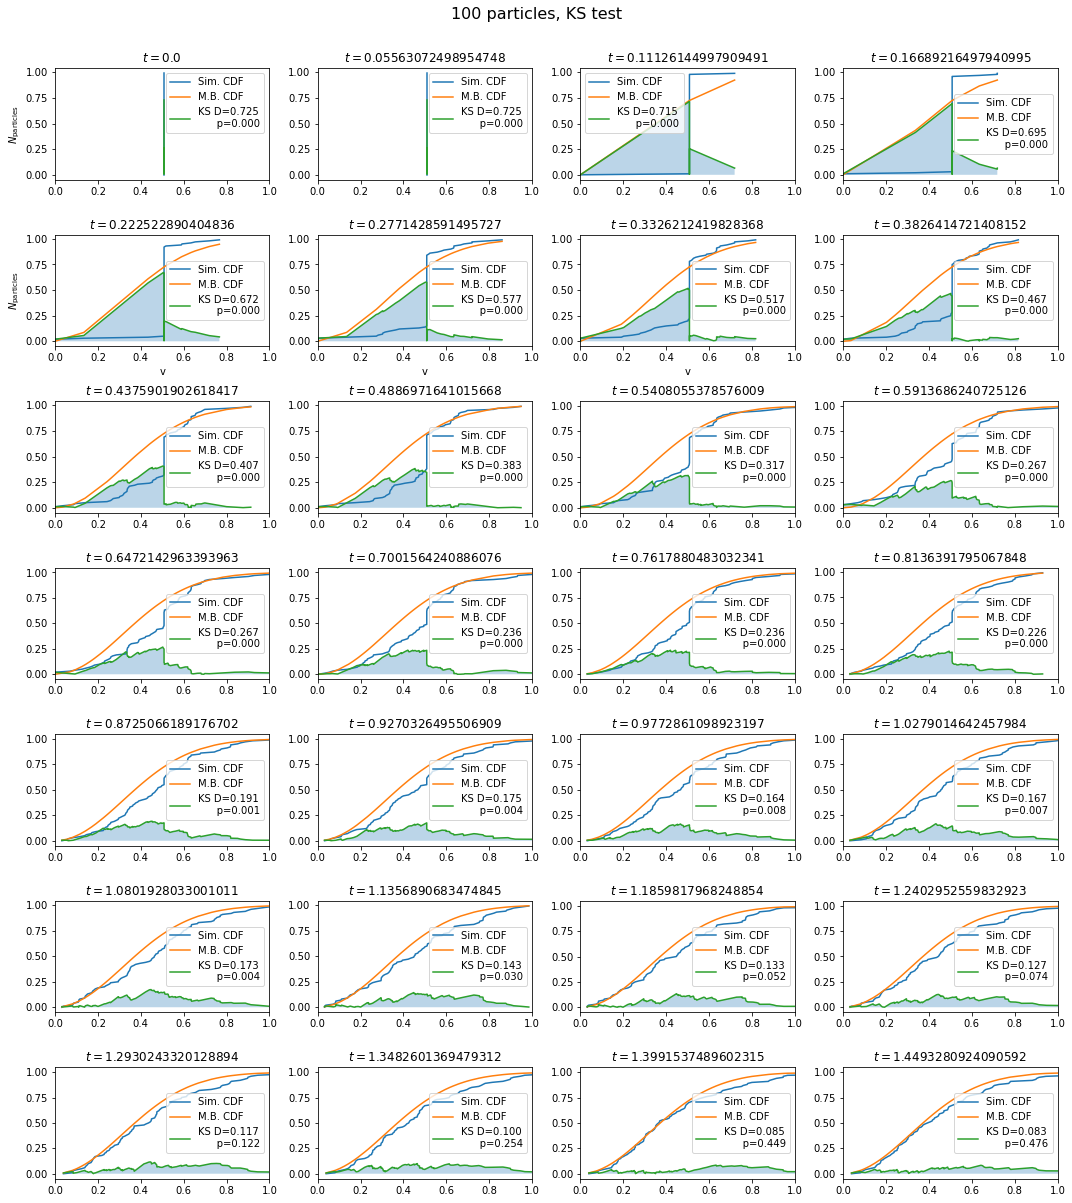

In [20]:
def KS_test_plots(data, shape=(3,3), figsize=(15, 15), title="???", scale=0.1, xlim=(0, 1)):
    ny, nx = shape
    fig, axes = plt.subplots(nx, ny, figsize=figsize)
    plt.suptitle(title, fontsize=16)

    ax = np.ravel(axes)
    for i in range(nx*ny):
        vx, vy, t = data[i]["vx"], data[i]["vy"], data[i]["t"][0]
        v = np.sqrt(vx**2+vy**2)

        # get sim cdf
        v = np.sort(v)
        N = len(v)
        vcdf = np.array(range(N))/float(N)

        #get MB 2D cdf dist.
        mxwl = maxwell2Dcdf(v, scale=scale)
        mxwlcdf = lambda x: maxwell2Dcdf(x, scale=scale)

        # run KS test
        ksdiff = abs(mxwl-vcdf)
        ks = kstest(v, mxwlcdf)

        # plot it
        ax[i].plot(v, vcdf, label="Sim. CDF")
        ax[i].plot(v, mxwl, label="M.B. CDF")
        lbl = "KS D={0:.3f}\n      p={1:.3f}"
        ax[i].plot(v, ksdiff, label=lbl.format(ks.statistic, ks.pvalue))
        ax[i].fill_between(v, ksdiff, alpha=0.3)

        ax[i].set_xlim(xlim)
        ax[i].set_title(r"$t={0}$".format(t))
        ax[i].legend()


    axes[1,0].set_xlabel(r"v")
    axes[1,1].set_xlabel(r"v")
    axes[1,2].set_xlabel(r"v")

    axes[0,0].set_ylabel(r"$N_{\mathrm{particles}}$")
    axes[1,0].set_ylabel(r"$N_{\mathrm{particles}}$")

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
folderpath = "100p_5s_ordered_ekinconstr_normal2"
simdat = nbody.sim_data(folderpath)
KS_test_plots(simdat, (4, 7), (15, 17), scale=0.2, title="100 particles, KS test")

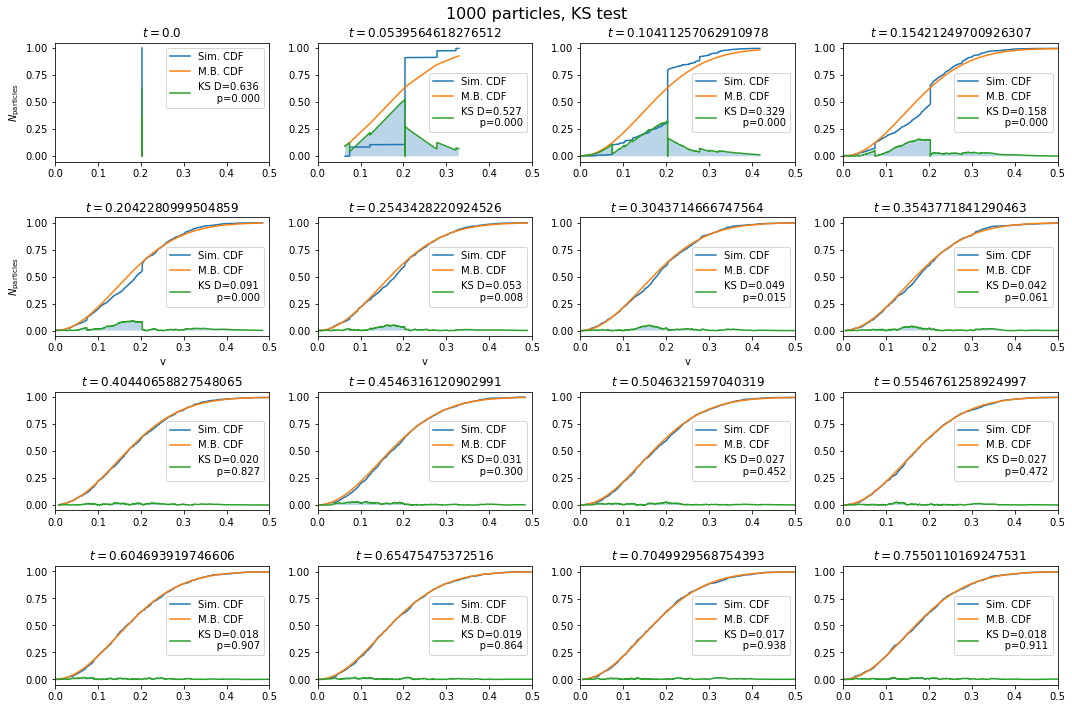

In [25]:
folderpath = "1000p_5s_ordered_ekinconstr_normal"
simdat = nbody.sim_data(folderpath)
KS_test_plots(simdat, (4, 4), (15, 10), scale=0.041, title="1000 particles, KS test", xlim=(0, 0.5))

### Defend the approach by simulating different scenarios for number of particles, cross sections and per particle energies.

Most of this was already done analysis done above - i.e. changing per particle energies and radii such that the total energy matches up, or such that the per particle energies are equal but the total energy is not. 

Bellow I explore some other possible simulation systems. First is the 300 particles in `ordered` positions with `ekin_constrained` velocities. I find interesting that at certain point the simulation completely deviates away from MB dist. after seemingly equilibrating - only to return back to it 0.3 to 0.4 seconds later. I have no explanation for this but the period corresponds to the period after minimal total energy was reached and the total energy suddenly re-normalized. 

Average total energy of the system is 250.00000000002314eV.
Maximal total energy of the system is 250.0000000000315eV.
Minimal total energy of the system is 250.00000000000003eV.


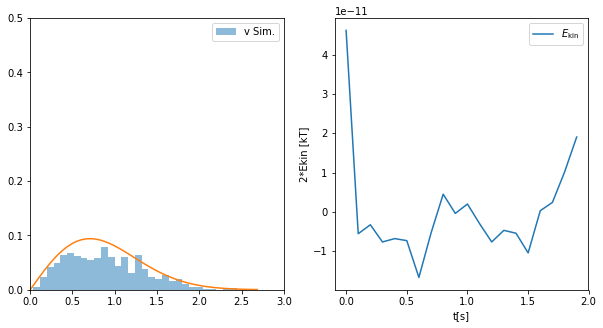

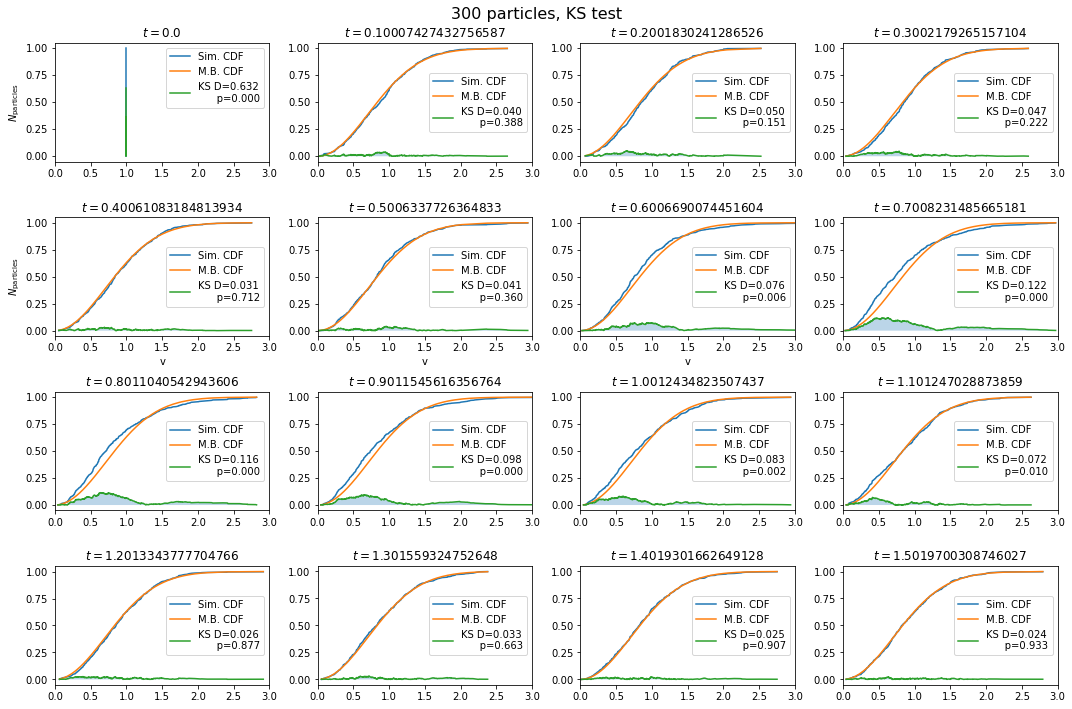

In [34]:
import nbody
import matplotlib.pyplot as plt
import scipy as scp

folderpath="test/10/"
simdat = nbody.sim_data(folderpath)

plot_v_totekin(simdat, scale=1, bins=30, alpha=0.5, ylim=(0, 0.5), xlim=(0, 3))
KS_test_plots(simdat, (4, 4,), (15, 10), r"300 particles, KS test", scale=1, xlim=(0, 3))

The simulation should perform similarly to systems described above even when a mixture of particles with different mass are introduced. The velocity distribution of the mixture of the two different types of particles should follow Max.-Boltz. distribution, provided the system has reached equilibrium. This is evident by the graphs bellow. Notice it takes about twice as long as simulation with uniform masses.

Average total energy of the system is 12.925000000002802eV.
Maximal total energy of the system is 12.925000000003513eV.
Minimal total energy of the system is 12.924999999999729eV.


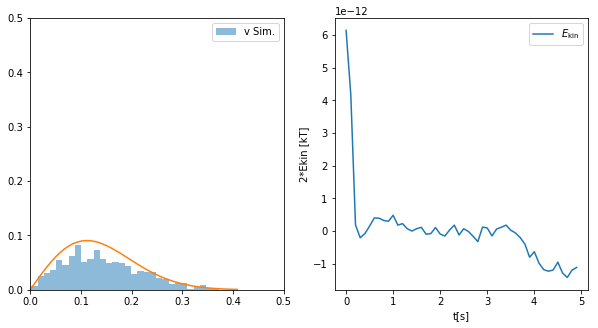

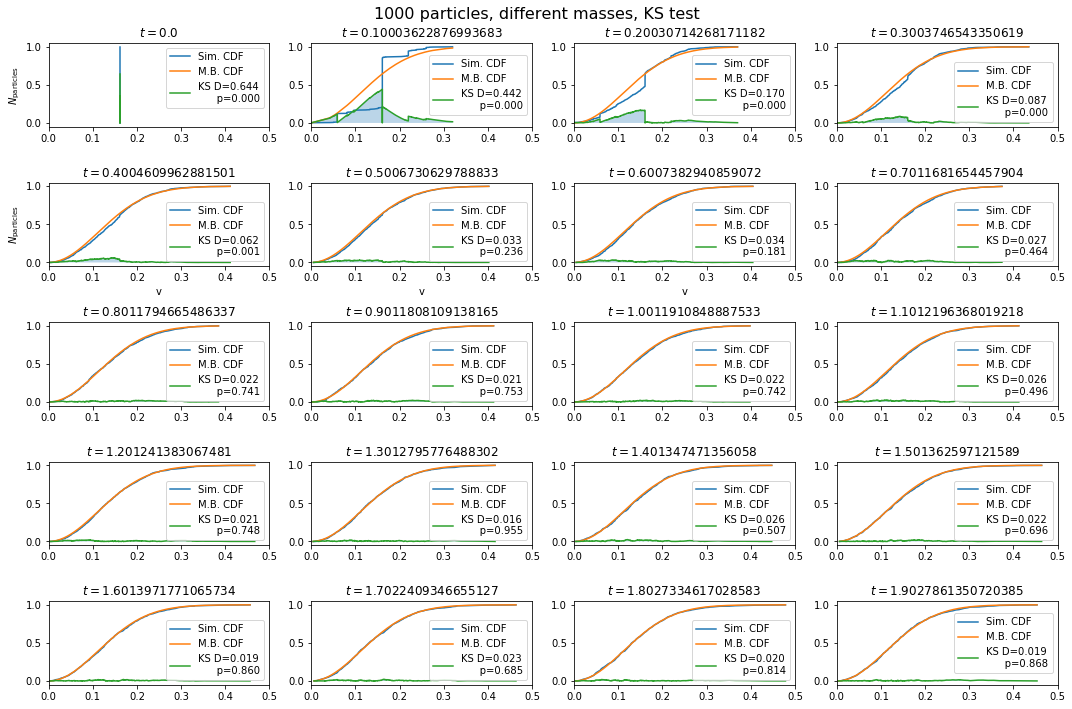

In [212]:
folderpath = "1000p_5s_ordered_ekinconstr_mass3/"
simdat = nbody.sim_data(folderpath)

plot_v_totekin(simdat, scale=0.025, bins=30, alpha=0.5, ylim=(0, 0.5), xlim=(0, 0.5))
KS_test_plots(simdat, (4, 5), (15, 10), r"1000 particles, different masses, KS test", scale=0.025, xlim=(0, 0.5))

## Conclusions

Presented are results of an event based simulation of particles in a box. Simulation is adapted from the [Event Driven Simulation](https://algs4.cs.princeton.edu/61event/) chapter from the textbook Algorithms, 4th Edition by Robert Sedgewick and Kevin Wayn. Their approach was given a more optimized implementation and a wider abstraction. There are several diferent initial conditions readily availible and the option to substitute your own initial condition generator function. Availible are `ordered` and `random` initial positions and `identical`, `Ekin_constrained` and `random` initial velocities conditions. Simulation executes in real time for smaller number of particles ($N$ less than couple of hundreds).           
Correctness of implementation was performed by manually colliding several well-known cases of elastic head-on collisions, which the code seems to have executed correctly. Units were verified by comparing the most probable velocity from the simulation to 

Analysis of the results of the simulation shows a stable execution for a wide variety of initial conditions (particle numbers, masses, per particle kinetic energy etc.). A slow convergence, in simulation time, towards Maxwell-Bolzman distribution is especially evident when simulating small number of particles (when collisions are not very frequent) placed in `ordered` fashion at the start of the simulation.                

Inspecting the changes in total energy of the system as a function of time showed very small net changes that fluctuate around the average value. The distribution of the number of particles as a function of the magnitude of velocity was derived. Visual comparison of the end velocity distribution averaged over several time steps and the derived theoretical Maxwell-Boltzman distribution was performed and showed satisfying overlap. Nota bene that the statistics for the case of a small number of particles is not very strong, with occupations of velocity bins being on the order of 10 particles even for the most probable velocities. Therefore the test was repeated on a 1000 particle simulation which showed much stonger overlap.

The similarity of the end distribution and the underlying Maxwell-Boltzman distribution is finally quantified at the end by performing a Kolmogorov-Smirnov test. Satisfying convergence towards MB dist. is usually achieved within a second of simulation time. Do notice that KS test is very sensitive to the choice of the **exact** scaling factor used - for example changing the scaling factor of a 1000 particle example with different masses by just 0.001 will lead to a much slower convergence to MB distribution.

Caution is in order, also, when dealing with event based simulations because of the very biased sampling that can occur. For small `save_t` values, poor initial conditions, or small number of particles the sampling can group around a small set of events that that could changed the state of only a small number of particles. In those cases using those snapshots in averaging schemes is equivalent of adding the previous state again because majority of the particles are still in the same state they were before the event. It is users responsibility to track that the average number of collisions per particle between two snapshots is at least approximately 1.        
This leads us to another, less precise but convenient even for large number of particles, estimator of the convergence towards MB distribution. Different systems seem to equilibrate approximately somewhere after 5 to 15 average collisions per particle occured with the larger systems requiring less average number of collisions. 